In [1]:
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import shutil
import sys
import matplotlib.pyplot as plt
import warnings
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
shutil.rmtree("../logs/AutoEncoder")

# ハイパーパラメータ

In [2]:
# 入力次元
X_n = 784
# Encoder入力
enc_n = [500, 300]
enc_layer_n = len(enc_n)
# Decoder入力
dec_n = [300, 500]
dec_layer_n = len(dec_n)
# 潜在変数Zの次元
Z_n = 20
# 学習回数
epoch_n = 10
# バッチサイズ
batch_size = 100

# 入力データ

In [3]:
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)
train_X = mnist.train.images
validation_X = mnist.validation.images
test_X = mnist.test.images

Extracting ../MNIST_data\train-images-idx3-ubyte.gz
Extracting ../MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data\t10k-labels-idx1-ubyte.gz


# モデルアーキテクチャ

In [4]:
# X
with tf.name_scope("X"):
    X = tf.placeholder(tf.float32, [None, X_n])

# Encoder
with tf.name_scope("Encoder"):
    enc_w = []
    enc_b = []
    enc_h = []
    for i, n in enumerate(enc_n):
        input_shape = [X_n if i == 0 else enc_n[i - 1], enc_n[i]]
        with tf.name_scope("Layer%02d" % (i + 1)):
            enc_w.append(tf.Variable(tf.truncated_normal(input_shape, stddev=0.1)))
            enc_b.append(tf.Variable(tf.truncated_normal([enc_n[i]], stddev=0.1)))
            enc_h.append(tf.nn.relu(tf.matmul(X if i == 0 else enc_h[i - 1], enc_w[i]) + enc_b[i]))

# Z
with tf.name_scope("Z"):
    Z_w = tf.Variable(tf.truncated_normal([enc_n[enc_layer_n - 1], Z_n], stddev=0.1))
    Z_b = tf.Variable(tf.truncated_normal([Z_n], stddev=0.1))
    Z = tf.nn.relu(tf.matmul(enc_h[enc_layer_n - 1], Z_w) + Z_b)

# Decoder
with tf.name_scope("Decoder"):
    dec_w = []
    dec_b = []
    dec_h = []
    for i, n in enumerate(dec_n):
        input_shape = [Z_n if i == 0 else dec_n[i - 1], dec_n[i]]
        with tf.name_scope("Layer%02d" % (i + 1)):
            dec_w.append(tf.Variable(tf.truncated_normal(input_shape, stddev=0.1)))
            dec_b.append(tf.Variable(tf.truncated_normal([dec_n[i]], stddev=0.1)))
            dec_h.append(tf.nn.relu(tf.matmul(Z if i == 0 else dec_h[i - 1], dec_w[i]) + dec_b[i]))

# G
with tf.name_scope("G"):
    G_w = tf.Variable(tf.truncated_normal([dec_n[dec_layer_n - 1], X_n], stddev=0.1))
    G_b = tf.Variable(tf.truncated_normal([X_n], stddev=0.1))
    G = tf.sigmoid(tf.matmul(dec_h[dec_layer_n - 1], G_w) + G_b)

# loss
with tf.name_scope("loss"):
    loss = tf.nn.l2_loss(G - X)

# Optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# セッション開始

In [5]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
writer = tf.summary.FileWriter('../logs/AutoEncoder', sess.graph)

# トレーニング

In [6]:
iteration_n = len(train_X) // batch_size
for epoch in range(epoch_n):
    sff_X = np.random.permutation(train_X)
    for iteration in range(iteration_n - 1):
        batch = sff_X[batch_size * iteration:batch_size * (iteration + 1)]
        sess.run(opt, feed_dict={X: batch})
    train_loss = sess.run(loss, feed_dict={X: batch})
    sys.stdout.write("\repoch: %d, loss: %.3f" % (epoch + 1, train_loss))
    sys.stdout.flush()

epoch: 10, loss: 410.455

# 性能評価

In [7]:
score = sess.run(loss, feed_dict={X: test_X}) / batch_size
print(score)

422.2974609375


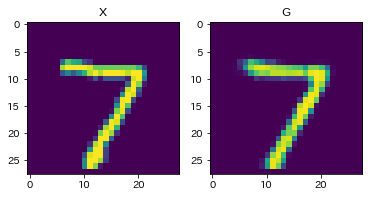

In [8]:
generate_images = sess.run(G, feed_dict={X: test_X})
plt.figure()
plt.subplot(1, 2, 1)
plt.title("X")
plt.imshow(test_X[0].reshape(28, 28))
plt.subplot(1, 2, 2)
plt.title("G")
plt.imshow(generate_images[0].reshape(28, 28))